In [65]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

import os

In [66]:
files = [file for r,d,f in os.walk('/Users/tommasaso/Applications/AI/SpeakerRecognition/DataSet/train-other-500') for file in f]
files.remove('.DS_Store')
files = list(filter(lambda s: s.endswith('.flac'), files))
df = pd.DataFrame(files, columns=["files"])
speaker = []
subfolder = []
for i in range(0, len(files)):
    speaker.append(df['files'][i].split('-')[0])
    subfolder.append(df['files'][i].split('-')[1])
df['speaker'] = speaker
df['subfolder'] = subfolder
df.head()

,files,speaker,subfolder
0,797-127183-0031.flac,797,127183
1,797-127183-0027.flac,797,127183
2,797-127183-0007.flac,797,127183
3,797-127183-0050.flac,797,127183
4,797-127183-0046.flac,797,127183


In [67]:
data = pd.read_fwf('/Users/tommasaso/Applications/AI/SpeakerRecognition/DataSet/SPEAKERS.TXT', delimiter="|", header=None, dtype=None, encoding='utf-8', index=False, comment=';', names=['speaker','gender','dataset','time','speaker_name'])
data[['speaker']] = data[['speaker']].applymap(np.int64)
def fn(row):
    global data 
    return data[(data['speaker'] == int(row['speaker'])) & (data.dataset.str.contains('train-other-500',case=False))].speaker_name.values[0]

df['speaker_name'] = df.apply(fn, axis=1)

In [68]:
#df_reduced = df.sample(frac=0.05, replace=True, random_state=1)
df = shuffle(df)
speakers = df['speaker'].unique()
speakers = speakers[:round(df['speaker'].nunique()/20)]
if not('0' in speakers):
    speakers = np.append(speakers, '0')
if not('1' in speakers):
    speakers = np.append(speakers, '1')
df_reduced=df[df['speaker'].isin(speakers)]

# Checking the number of speakers or the number of different people in our voice data
print("Number of sample: "+str(len(df)))
print("Number of sample reduced: "+str(len(df_reduced)))
print("Number of speaker: " + str(df['speaker'].nunique()))
print("Number of speaker reduced: " + str(df_reduced['speaker'].nunique()))

df_reduced = df_reduced.copy()
df_reduced['speaker'] = df_reduced['speaker'].astype(int)
sample = 0

Number of sample: 148834
Number of sample reduced: 8072
Number of speaker: 1168
Number of speaker reduced: 60


In [69]:
def extract_features(files):
    
    global sample
    sample = sample+1
    print("Sample: "+str(sample))
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('DataSet/train-other-500')+'/'+str(files.speaker)+'/'+str(files.subfolder)+'/'+str(files.files))

    # Loads the audio file as a floating point time series - default sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    
    X, index = librosa.effects.trim(y=X, top_db=40)

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)

    return mfccs, chroma, mel, contrast, tonnetz

In [70]:
features_label = df_reduced.apply(extract_features, axis=1)

Sample: 1
Sample: 2
Sample: 3
Sample: 4
Sample: 5
Sample: 6
Sample: 7
Sample: 8
Sample: 9
Sample: 10
Sample: 11
Sample: 12
Sample: 13
Sample: 14
Sample: 15
Sample: 16
Sample: 17
Sample: 18
Sample: 19
Sample: 20
Sample: 21
Sample: 22
Sample: 23
Sample: 24
Sample: 25
Sample: 26
Sample: 27
Sample: 28
Sample: 29
Sample: 30
Sample: 31
Sample: 32
Sample: 33
Sample: 34
Sample: 35
Sample: 36
Sample: 37
Sample: 38
Sample: 39
Sample: 40
Sample: 41
Sample: 42
Sample: 43
Sample: 44
Sample: 45
Sample: 46
Sample: 47
Sample: 48
Sample: 49
Sample: 50
Sample: 51
Sample: 52
Sample: 53
Sample: 54
Sample: 55
Sample: 56
Sample: 57
Sample: 58
Sample: 59
Sample: 60
Sample: 61
Sample: 62
Sample: 63
Sample: 64
Sample: 65
Sample: 66
Sample: 67
Sample: 68
Sample: 69
Sample: 70
Sample: 71
Sample: 72
Sample: 73
Sample: 74
Sample: 75
Sample: 76
Sample: 77
Sample: 78
Sample: 79
Sample: 80
Sample: 81
Sample: 82
Sample: 83
Sample: 84
Sample: 85
Sample: 86
Sample: 87
Sample: 88
Sample: 89
Sample: 90
Sample: 91
Sample: 

/opt/anaconda3/envs/tens/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


Sample: 334
Sample: 335
Sample: 336
Sample: 337
Sample: 338
Sample: 339
Sample: 340
Sample: 341
Sample: 342
Sample: 343
Sample: 344
Sample: 345
Sample: 346
Sample: 347
Sample: 348
Sample: 349
Sample: 350
Sample: 351
Sample: 352
Sample: 353
Sample: 354
Sample: 355
Sample: 356
Sample: 357
Sample: 358
Sample: 359
Sample: 360
Sample: 361
Sample: 362
Sample: 363
Sample: 364
Sample: 365
Sample: 366
Sample: 367
Sample: 368
Sample: 369
Sample: 370
Sample: 371
Sample: 372
Sample: 373
Sample: 374
Sample: 375
Sample: 376
Sample: 377
Sample: 378
Sample: 379
Sample: 380
Sample: 381
Sample: 382
Sample: 383
Sample: 384
Sample: 385
Sample: 386
Sample: 387
Sample: 388
Sample: 389
Sample: 390
Sample: 391
Sample: 392
Sample: 393
Sample: 394
Sample: 395
Sample: 396
Sample: 397
Sample: 398
Sample: 399
Sample: 400
Sample: 401
Sample: 402
Sample: 403
Sample: 404
Sample: 405
Sample: 406
Sample: 407
Sample: 408
Sample: 409
Sample: 410
Sample: 411
Sample: 412
Sample: 413
Sample: 414
Sample: 415
Sample: 416
Samp

Sample: 1016
Sample: 1017
Sample: 1018
Sample: 1019
Sample: 1020
Sample: 1021
Sample: 1022
Sample: 1023
Sample: 1024
Sample: 1025
Sample: 1026
Sample: 1027
Sample: 1028
Sample: 1029
Sample: 1030
Sample: 1031
Sample: 1032
Sample: 1033
Sample: 1034
Sample: 1035
Sample: 1036
Sample: 1037
Sample: 1038
Sample: 1039
Sample: 1040
Sample: 1041
Sample: 1042
Sample: 1043
Sample: 1044
Sample: 1045
Sample: 1046
Sample: 1047
Sample: 1048
Sample: 1049
Sample: 1050
Sample: 1051
Sample: 1052
Sample: 1053
Sample: 1054
Sample: 1055
Sample: 1056
Sample: 1057
Sample: 1058
Sample: 1059
Sample: 1060
Sample: 1061
Sample: 1062
Sample: 1063
Sample: 1064
Sample: 1065
Sample: 1066
Sample: 1067
Sample: 1068
Sample: 1069
Sample: 1070
Sample: 1071
Sample: 1072
Sample: 1073
Sample: 1074
Sample: 1075
Sample: 1076
Sample: 1077
Sample: 1078
Sample: 1079
Sample: 1080
Sample: 1081
Sample: 1082
Sample: 1083
Sample: 1084
Sample: 1085
Sample: 1086
Sample: 1087
Sample: 1088
Sample: 1089
Sample: 1090
Sample: 1091
Sample: 1092

Sample: 1647
Sample: 1648
Sample: 1649
Sample: 1650
Sample: 1651
Sample: 1652
Sample: 1653
Sample: 1654
Sample: 1655
Sample: 1656
Sample: 1657
Sample: 1658
Sample: 1659
Sample: 1660
Sample: 1661
Sample: 1662
Sample: 1663
Sample: 1664
Sample: 1665
Sample: 1666
Sample: 1667
Sample: 1668
Sample: 1669
Sample: 1670
Sample: 1671
Sample: 1672
Sample: 1673
Sample: 1674
Sample: 1675
Sample: 1676
Sample: 1677
Sample: 1678
Sample: 1679
Sample: 1680
Sample: 1681
Sample: 1682
Sample: 1683
Sample: 1684
Sample: 1685
Sample: 1686
Sample: 1687
Sample: 1688
Sample: 1689
Sample: 1690
Sample: 1691
Sample: 1692
Sample: 1693
Sample: 1694
Sample: 1695
Sample: 1696
Sample: 1697
Sample: 1698
Sample: 1699
Sample: 1700
Sample: 1701
Sample: 1702
Sample: 1703
Sample: 1704
Sample: 1705
Sample: 1706
Sample: 1707
Sample: 1708
Sample: 1709
Sample: 1710
Sample: 1711
Sample: 1712
Sample: 1713
Sample: 1714
Sample: 1715
Sample: 1716
Sample: 1717
Sample: 1718
Sample: 1719
Sample: 1720
Sample: 1721
Sample: 1722
Sample: 1723

Sample: 2278
Sample: 2279
Sample: 2280
Sample: 2281
Sample: 2282
Sample: 2283
Sample: 2284
Sample: 2285
Sample: 2286
Sample: 2287
Sample: 2288
Sample: 2289
Sample: 2290
Sample: 2291
Sample: 2292
Sample: 2293
Sample: 2294
Sample: 2295
Sample: 2296
Sample: 2297
Sample: 2298
Sample: 2299
Sample: 2300
Sample: 2301
Sample: 2302
Sample: 2303
Sample: 2304
Sample: 2305
Sample: 2306
Sample: 2307
Sample: 2308
Sample: 2309
Sample: 2310
Sample: 2311
Sample: 2312
Sample: 2313
Sample: 2314
Sample: 2315
Sample: 2316
Sample: 2317
Sample: 2318
Sample: 2319
Sample: 2320
Sample: 2321
Sample: 2322
Sample: 2323
Sample: 2324
Sample: 2325
Sample: 2326
Sample: 2327
Sample: 2328
Sample: 2329
Sample: 2330
Sample: 2331
Sample: 2332
Sample: 2333
Sample: 2334
Sample: 2335
Sample: 2336
Sample: 2337
Sample: 2338
Sample: 2339
Sample: 2340
Sample: 2341
Sample: 2342
Sample: 2343
Sample: 2344
Sample: 2345
Sample: 2346
Sample: 2347
Sample: 2348
Sample: 2349
Sample: 2350
Sample: 2351
Sample: 2352
Sample: 2353
Sample: 2354

Sample: 2909
Sample: 2910
Sample: 2911
Sample: 2912
Sample: 2913
Sample: 2914
Sample: 2915
Sample: 2916
Sample: 2917
Sample: 2918
Sample: 2919
Sample: 2920
Sample: 2921
Sample: 2922
Sample: 2923
Sample: 2924
Sample: 2925
Sample: 2926
Sample: 2927
Sample: 2928
Sample: 2929
Sample: 2930
Sample: 2931
Sample: 2932
Sample: 2933
Sample: 2934
Sample: 2935
Sample: 2936
Sample: 2937
Sample: 2938
Sample: 2939
Sample: 2940
Sample: 2941
Sample: 2942
Sample: 2943
Sample: 2944
Sample: 2945
Sample: 2946
Sample: 2947
Sample: 2948
Sample: 2949
Sample: 2950
Sample: 2951
Sample: 2952
Sample: 2953
Sample: 2954
Sample: 2955
Sample: 2956
Sample: 2957
Sample: 2958
Sample: 2959
Sample: 2960
Sample: 2961
Sample: 2962
Sample: 2963
Sample: 2964
Sample: 2965
Sample: 2966
Sample: 2967
Sample: 2968
Sample: 2969
Sample: 2970
Sample: 2971
Sample: 2972
Sample: 2973
Sample: 2974
Sample: 2975
Sample: 2976
Sample: 2977
Sample: 2978
Sample: 2979
Sample: 2980
Sample: 2981
Sample: 2982
Sample: 2983
Sample: 2984
Sample: 2985

Sample: 3540
Sample: 3541
Sample: 3542
Sample: 3543
Sample: 3544
Sample: 3545
Sample: 3546
Sample: 3547
Sample: 3548
Sample: 3549
Sample: 3550
Sample: 3551
Sample: 3552
Sample: 3553
Sample: 3554
Sample: 3555
Sample: 3556
Sample: 3557
Sample: 3558
Sample: 3559
Sample: 3560
Sample: 3561
Sample: 3562
Sample: 3563
Sample: 3564
Sample: 3565
Sample: 3566
Sample: 3567
Sample: 3568
Sample: 3569
Sample: 3570
Sample: 3571
Sample: 3572
Sample: 3573
Sample: 3574
Sample: 3575
Sample: 3576
Sample: 3577
Sample: 3578
Sample: 3579
Sample: 3580
Sample: 3581
Sample: 3582
Sample: 3583
Sample: 3584
Sample: 3585
Sample: 3586
Sample: 3587
Sample: 3588
Sample: 3589
Sample: 3590
Sample: 3591
Sample: 3592
Sample: 3593
Sample: 3594
Sample: 3595
Sample: 3596
Sample: 3597
Sample: 3598
Sample: 3599
Sample: 3600
Sample: 3601
Sample: 3602
Sample: 3603
Sample: 3604
Sample: 3605
Sample: 3606
Sample: 3607
Sample: 3608
Sample: 3609
Sample: 3610
Sample: 3611
Sample: 3612
Sample: 3613
Sample: 3614
Sample: 3615
Sample: 3616

Sample: 4171
Sample: 4172
Sample: 4173
Sample: 4174
Sample: 4175
Sample: 4176
Sample: 4177
Sample: 4178
Sample: 4179
Sample: 4180
Sample: 4181
Sample: 4182
Sample: 4183
Sample: 4184
Sample: 4185
Sample: 4186
Sample: 4187
Sample: 4188
Sample: 4189
Sample: 4190
Sample: 4191
Sample: 4192
Sample: 4193
Sample: 4194
Sample: 4195
Sample: 4196
Sample: 4197
Sample: 4198
Sample: 4199
Sample: 4200
Sample: 4201
Sample: 4202
Sample: 4203
Sample: 4204
Sample: 4205
Sample: 4206
Sample: 4207
Sample: 4208
Sample: 4209
Sample: 4210
Sample: 4211
Sample: 4212
Sample: 4213
Sample: 4214
Sample: 4215
Sample: 4216
Sample: 4217
Sample: 4218
Sample: 4219
Sample: 4220
Sample: 4221
Sample: 4222
Sample: 4223
Sample: 4224
Sample: 4225
Sample: 4226
Sample: 4227
Sample: 4228
Sample: 4229
Sample: 4230
Sample: 4231
Sample: 4232
Sample: 4233
Sample: 4234
Sample: 4235
Sample: 4236
Sample: 4237
Sample: 4238
Sample: 4239
Sample: 4240
Sample: 4241
Sample: 4242
Sample: 4243
Sample: 4244
Sample: 4245
Sample: 4246
Sample: 4247

Sample: 4802
Sample: 4803
Sample: 4804
Sample: 4805
Sample: 4806
Sample: 4807
Sample: 4808
Sample: 4809
Sample: 4810
Sample: 4811
Sample: 4812
Sample: 4813
Sample: 4814
Sample: 4815
Sample: 4816
Sample: 4817
Sample: 4818
Sample: 4819
Sample: 4820
Sample: 4821
Sample: 4822
Sample: 4823
Sample: 4824
Sample: 4825
Sample: 4826
Sample: 4827
Sample: 4828
Sample: 4829
Sample: 4830
Sample: 4831
Sample: 4832
Sample: 4833
Sample: 4834
Sample: 4835
Sample: 4836
Sample: 4837
Sample: 4838
Sample: 4839
Sample: 4840
Sample: 4841
Sample: 4842
Sample: 4843
Sample: 4844
Sample: 4845
Sample: 4846
Sample: 4847
Sample: 4848
Sample: 4849
Sample: 4850
Sample: 4851
Sample: 4852
Sample: 4853
Sample: 4854
Sample: 4855
Sample: 4856
Sample: 4857
Sample: 4858
Sample: 4859
Sample: 4860
Sample: 4861
Sample: 4862
Sample: 4863
Sample: 4864
Sample: 4865
Sample: 4866
Sample: 4867
Sample: 4868
Sample: 4869
Sample: 4870
Sample: 4871
Sample: 4872
Sample: 4873
Sample: 4874
Sample: 4875
Sample: 4876
Sample: 4877
Sample: 4878

Sample: 5433
Sample: 5434
Sample: 5435
Sample: 5436
Sample: 5437
Sample: 5438
Sample: 5439
Sample: 5440
Sample: 5441
Sample: 5442
Sample: 5443
Sample: 5444
Sample: 5445
Sample: 5446
Sample: 5447
Sample: 5448
Sample: 5449
Sample: 5450
Sample: 5451
Sample: 5452
Sample: 5453
Sample: 5454
Sample: 5455
Sample: 5456
Sample: 5457
Sample: 5458
Sample: 5459
Sample: 5460
Sample: 5461
Sample: 5462
Sample: 5463
Sample: 5464
Sample: 5465
Sample: 5466
Sample: 5467
Sample: 5468
Sample: 5469
Sample: 5470
Sample: 5471
Sample: 5472
Sample: 5473
Sample: 5474
Sample: 5475
Sample: 5476
Sample: 5477
Sample: 5478
Sample: 5479
Sample: 5480
Sample: 5481
Sample: 5482
Sample: 5483
Sample: 5484
Sample: 5485
Sample: 5486
Sample: 5487
Sample: 5488
Sample: 5489
Sample: 5490
Sample: 5491
Sample: 5492
Sample: 5493
Sample: 5494
Sample: 5495
Sample: 5496
Sample: 5497
Sample: 5498
Sample: 5499
Sample: 5500
Sample: 5501
Sample: 5502
Sample: 5503
Sample: 5504
Sample: 5505
Sample: 5506
Sample: 5507
Sample: 5508
Sample: 5509

Sample: 6064
Sample: 6065
Sample: 6066
Sample: 6067
Sample: 6068
Sample: 6069
Sample: 6070
Sample: 6071
Sample: 6072
Sample: 6073
Sample: 6074
Sample: 6075
Sample: 6076
Sample: 6077
Sample: 6078
Sample: 6079
Sample: 6080
Sample: 6081
Sample: 6082
Sample: 6083
Sample: 6084
Sample: 6085
Sample: 6086
Sample: 6087
Sample: 6088
Sample: 6089
Sample: 6090
Sample: 6091
Sample: 6092
Sample: 6093
Sample: 6094
Sample: 6095
Sample: 6096
Sample: 6097
Sample: 6098
Sample: 6099
Sample: 6100
Sample: 6101
Sample: 6102
Sample: 6103
Sample: 6104
Sample: 6105
Sample: 6106
Sample: 6107
Sample: 6108
Sample: 6109
Sample: 6110
Sample: 6111
Sample: 6112
Sample: 6113
Sample: 6114
Sample: 6115
Sample: 6116
Sample: 6117
Sample: 6118
Sample: 6119
Sample: 6120
Sample: 6121
Sample: 6122
Sample: 6123
Sample: 6124
Sample: 6125
Sample: 6126
Sample: 6127
Sample: 6128
Sample: 6129
Sample: 6130
Sample: 6131
Sample: 6132
Sample: 6133
Sample: 6134
Sample: 6135
Sample: 6136
Sample: 6137
Sample: 6138
Sample: 6139
Sample: 6140

Sample: 6695
Sample: 6696
Sample: 6697
Sample: 6698
Sample: 6699
Sample: 6700
Sample: 6701
Sample: 6702
Sample: 6703
Sample: 6704
Sample: 6705
Sample: 6706
Sample: 6707
Sample: 6708
Sample: 6709
Sample: 6710
Sample: 6711
Sample: 6712
Sample: 6713
Sample: 6714
Sample: 6715
Sample: 6716
Sample: 6717
Sample: 6718
Sample: 6719
Sample: 6720
Sample: 6721
Sample: 6722
Sample: 6723
Sample: 6724
Sample: 6725
Sample: 6726
Sample: 6727
Sample: 6728
Sample: 6729
Sample: 6730
Sample: 6731
Sample: 6732
Sample: 6733
Sample: 6734
Sample: 6735
Sample: 6736
Sample: 6737
Sample: 6738
Sample: 6739
Sample: 6740
Sample: 6741
Sample: 6742
Sample: 6743
Sample: 6744
Sample: 6745
Sample: 6746
Sample: 6747
Sample: 6748
Sample: 6749
Sample: 6750
Sample: 6751
Sample: 6752
Sample: 6753
Sample: 6754
Sample: 6755
Sample: 6756
Sample: 6757
Sample: 6758
Sample: 6759
Sample: 6760
Sample: 6761
Sample: 6762
Sample: 6763
Sample: 6764
Sample: 6765
Sample: 6766
Sample: 6767
Sample: 6768
Sample: 6769
Sample: 6770
Sample: 6771

Sample: 7326
Sample: 7327
Sample: 7328
Sample: 7329
Sample: 7330
Sample: 7331
Sample: 7332
Sample: 7333
Sample: 7334
Sample: 7335
Sample: 7336
Sample: 7337
Sample: 7338
Sample: 7339
Sample: 7340
Sample: 7341
Sample: 7342
Sample: 7343
Sample: 7344
Sample: 7345
Sample: 7346
Sample: 7347
Sample: 7348
Sample: 7349
Sample: 7350
Sample: 7351
Sample: 7352
Sample: 7353
Sample: 7354
Sample: 7355
Sample: 7356
Sample: 7357
Sample: 7358
Sample: 7359
Sample: 7360
Sample: 7361
Sample: 7362
Sample: 7363
Sample: 7364
Sample: 7365
Sample: 7366
Sample: 7367
Sample: 7368
Sample: 7369
Sample: 7370
Sample: 7371
Sample: 7372
Sample: 7373
Sample: 7374
Sample: 7375
Sample: 7376
Sample: 7377
Sample: 7378
Sample: 7379
Sample: 7380
Sample: 7381
Sample: 7382
Sample: 7383
Sample: 7384
Sample: 7385
Sample: 7386
Sample: 7387
Sample: 7388
Sample: 7389
Sample: 7390
Sample: 7391
Sample: 7392
Sample: 7393
Sample: 7394
Sample: 7395
Sample: 7396
Sample: 7397
Sample: 7398
Sample: 7399
Sample: 7400
Sample: 7401
Sample: 7402

Sample: 7957
Sample: 7958
Sample: 7959
Sample: 7960
Sample: 7961
Sample: 7962
Sample: 7963
Sample: 7964
Sample: 7965
Sample: 7966
Sample: 7967
Sample: 7968
Sample: 7969
Sample: 7970
Sample: 7971
Sample: 7972
Sample: 7973
Sample: 7974
Sample: 7975
Sample: 7976
Sample: 7977
Sample: 7978
Sample: 7979
Sample: 7980
Sample: 7981
Sample: 7982
Sample: 7983
Sample: 7984
Sample: 7985
Sample: 7986
Sample: 7987
Sample: 7988
Sample: 7989
Sample: 7990
Sample: 7991
Sample: 7992
Sample: 7993
Sample: 7994
Sample: 7995
Sample: 7996
Sample: 7997
Sample: 7998
Sample: 7999
Sample: 8000
Sample: 8001
Sample: 8002
Sample: 8003
Sample: 8004
Sample: 8005
Sample: 8006
Sample: 8007
Sample: 8008
Sample: 8009
Sample: 8010
Sample: 8011
Sample: 8012
Sample: 8013
Sample: 8014
Sample: 8015
Sample: 8016
Sample: 8017
Sample: 8018
Sample: 8019
Sample: 8020
Sample: 8021
Sample: 8022
Sample: 8023
Sample: 8024
Sample: 8025
Sample: 8026
Sample: 8027
Sample: 8028
Sample: 8029
Sample: 8030
Sample: 8031
Sample: 8032
Sample: 8033

In [71]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 
features = []

for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label.iloc[i][0], features_label.iloc[i][1], 
                features_label.iloc[i][2], features_label.iloc[i][3],
                features_label.iloc[i][4]), axis=0))
#print(features)

In [72]:
features_data = np.array(features)
for i in range(0,len(features[0])):
    df_reduced['feature_'+str(i)] = features_data[:,i]

In [86]:
import pickle 
#f = open('dataframe.pkl', 'wb') 
#pickle.dump(df_reduced, f)
f = open('dataframe.pkl', 'rb') 
df_reduced = pickle.load(f)

In [87]:
features_cols = [col for col in df_reduced if col.startswith('feature')]
X = df_reduced[features_cols].to_numpy()
y = df_reduced['speaker_name'].to_numpy()
lb = LabelEncoder()
y_dec = lb.fit_transform(y)
f_encoder = open('LabelEncoder.pkl', 'wb') 
pickle.dump(lb, f_encoder)

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y_dec, test_size=0.3, shuffle=False)

X_test = X_test_val[int(len(X_test_val)*0.5):len(X_test_val)]
X_val = X_test_val[0:int(len(X_test_val)*0.5)]
y_test = y_test_val[int(len(y_test_val)*0.5):len(y_test_val)]
y_val = y_test_val[0:int(len(y_test_val)*0.5)]

In [88]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)
f_scaler = open('StandardScaler.pkl', 'wb') 
pickle.dump(ss, f_scaler)

In [89]:
model = Sequential()

model.add(Dense(len(features_cols), input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(len(speakers), activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [90]:
# fitting the model with the train data and validation with the validation data
# we used early stop with patience 100 because we did not want to use early stop
# I leave the early stop regularization code in case anyone wants to use it

history = model.fit(X_train, to_categorical(y_train), batch_size=256, epochs=100, 
                    validation_data=(X_val,to_categorical(y_val)),
                    callbacks=[early_stop])                                

Train on 5650 samples, validate on 1211 samples
Epoch 1/100
5650/5650 [==============================] - 1s 193us/sample - loss: 3.8482 - accuracy: 0.0945 - val_loss: 3.2462 - val_accuracy: 0.3691
Epoch 2/100
5650/5650 [==============================] - 0s 55us/sample - loss: 2.9656 - accuracy: 0.2710 - val_loss: 1.9258 - val_accuracy: 0.6796
Epoch 3/100
5650/5650 [==============================] - 0s 54us/sample - loss: 2.0511 - accuracy: 0.4747 - val_loss: 0.9609 - val_accuracy: 0.9158
Epoch 4/100
5650/5650 [==============================] - 0s 54us/sample - loss: 1.3492 - accuracy: 0.6441 - val_loss: 0.4878 - val_accuracy: 0.9546
Epoch 5/100
5650/5650 [==============================] - 0s 54us/sample - loss: 0.9389 - accuracy: 0.7448 - val_loss: 0.2644 - val_accuracy: 0.9810
Epoch 6/100
5650/5650 [==============================] - 0s 54us/sample - loss: 0.6918 - accuracy: 0.8170 - val_loss: 0.1659 - val_accuracy: 0.9843
Epoch 7/100
5650/5650 [==============================] - 0s 54u

Epoch 56/100
5650/5650 [==============================] - 0s 59us/sample - loss: 0.0278 - accuracy: 0.9913 - val_loss: 0.0318 - val_accuracy: 0.9959
Epoch 57/100
5650/5650 [==============================] - 0s 59us/sample - loss: 0.0203 - accuracy: 0.9947 - val_loss: 0.0273 - val_accuracy: 0.9959
Epoch 58/100
5650/5650 [==============================] - 0s 58us/sample - loss: 0.0283 - accuracy: 0.9922 - val_loss: 0.0309 - val_accuracy: 0.9959
Epoch 59/100
5650/5650 [==============================] - 0s 58us/sample - loss: 0.0286 - accuracy: 0.9926 - val_loss: 0.0347 - val_accuracy: 0.9967
Epoch 60/100
5650/5650 [==============================] - 0s 58us/sample - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.0336 - val_accuracy: 0.9967
Epoch 61/100
5650/5650 [==============================] - 0s 58us/sample - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.0313 - val_accuracy: 0.9967
Epoch 62/100
5650/5650 [==============================] - 0s 58us/sample - loss: 0.0216 - accuracy: 0.9945

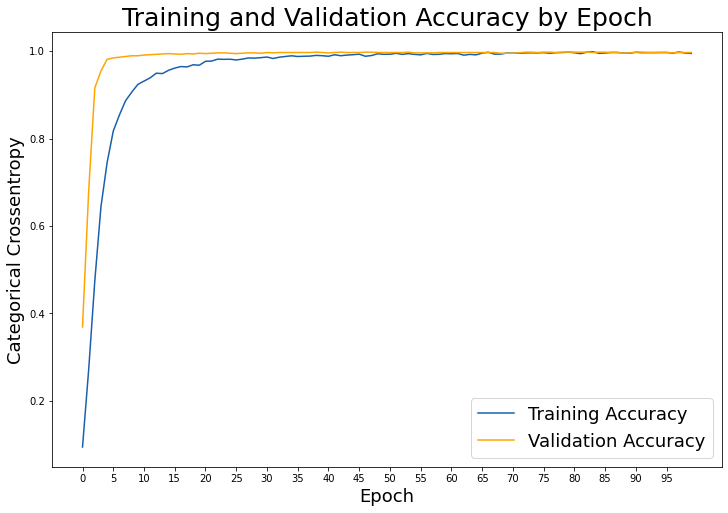

In [91]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

Model Accuracy: 0.9983484723369116
MSE: 0.7241948802642444
INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


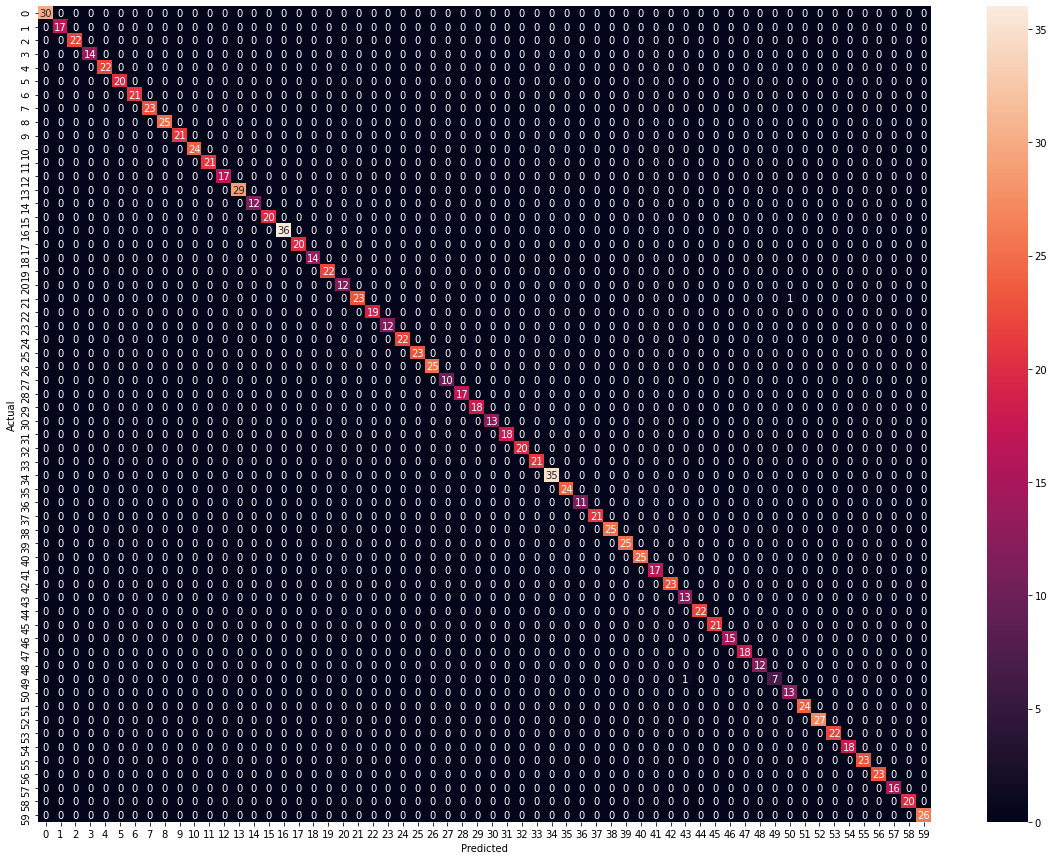

In [92]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sn
y_pred = model.predict_classes(X_test)

print("Model Accuracy: "+str(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("MSE: "+str(mean_squared_error(y_test, y_pred)))

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.subplots(figsize=(20,15))
sn.heatmap(confusion_matrix, annot=True)

model.save('saved_model/my_model') 

In [101]:
import tensorflow as tf

data = {"files": "3-3-0002.flac", "speaker": "3", 'subfolder': "3"}
test = pd.DataFrame(data = data, index=[0])
features_label_test = test.apply(extract_features, axis=1)
features_test = []
features_test.append(np.concatenate((features_label_test.iloc[0][0], features_label_test.iloc[0][1], 
                features_label_test.iloc[0][2], features_label_test.iloc[0][3],
                features_label_test.iloc[0][4]), axis=0))
test = np.array(features_test)
#print(test)
test = ss.transform(test)
test_pred= model.predict_proba(test)
test_pred= model.predict_classes(test)
print(lb.inverse_transform(test_pred))
print(test_pred)

Sample: 8087
[' Silence']
[43]


In [19]:
model.save('saved_model/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
print(df_reduced[df_reduced['speaker_name'])
print(type(list(df_reduced['speaker_name'].unique())))

In [23]:
print(lb.inverse_transform([47]))
print(lb.transform([' Tommaso Elia']))

[' Tommaso Elia']
[47]


In [7]:
print(speakers)

['1901' '1544' '1643' '5720' '1784' '5198' '4211' '133' '5874' '7433'
 '1154' '3541' '147' '4295' '8328' '982' '7062' '5911' '7001' '4910' '453'
 '6849' '202' '2587' '690' '4009' '6625' '75' '448' '5077' '3470' '6323'
 '542' '3894' '218' '5653' '3479' '5983' '1250' '7155' '3798' '2104'
 '6368' '3928' '7640' '1715' '8272' '2374' '6945' '753' '4379' '3681'
 '7392' '1693' '4741' '6967' '7205' '7769' '1']


In [ ]:
df_reduced['speaker_name'].unique()